In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
from scipy.spatial import distance
from sklearn.metrics import silhouette_score

In [ ]:
df0 = pd.read_csv('c:/Users/gandh/dev/unv/smoed/NB/data/main_data.csv')
X = df0['nu']
Y = df0['E']

### Нормализация

In [52]:
X_norm = MinMaxScaler().fit_transform(df0)
df = pd.DataFrame(data=X_norm, columns=['nu','E'])
df.round(3).to_csv('data/df_norm.csv', index=False)

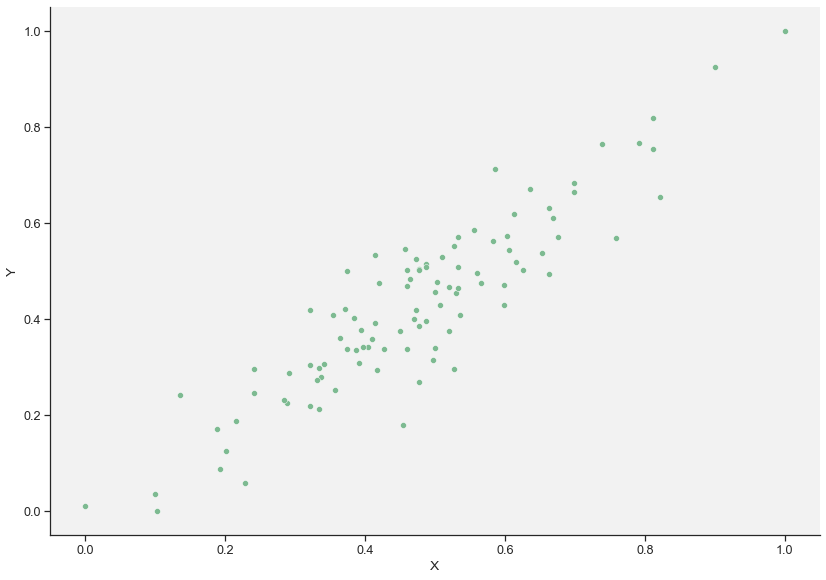

In [14]:
sns.set_theme(palette='crest', font_scale=1.15)
sns.set_style("ticks", {"axes.facecolor": ".95"})
ax = sns.relplot(data=df, x='nu', y='E', kind='scatter', height=8.27, aspect=11.7/8.27)
ax.set_axis_labels('X', 'Y')
plt.tight_layout()
plt.savefig('pics/1.png')

In [17]:
N = len(df)
sup_k = np.floor(np.sqrt(N/2))
sup_k

7.0

## Алгоритм

In [47]:
def sc_plots(data, means, Ncl, step):
    if Ncl > 6:
        ax = sns.relplot(data=data, x='nu', y='E', hue='кластер', kind='scatter', alpha=0.8,
                         height=8.27, aspect=11.7/8.27)
        plt.scatter(means[:,0],means[:,1], c='m', s=60)
    else:
        ax = sns.relplot(data=data, x='nu', y='E', hue='кластер', kind='scatter', palette='viridis', alpha=0.8,
                         height=8.27, aspect=11.7/8.27)
        plt.scatter(means[:,0],means[:,1], c='m', s=60)
    
    print(f'кластеры = {Ncl}; шаги = {step}')
    ax.set_axis_labels('X', 'Y')
    ax.fig.suptitle(f'{Ncl} кластера(ов)')
    plt.tight_layout()
    plt.savefig(f'pics/2_{Ncl}.png')
    plt.close()

In [48]:
def nearest_center(data, cts):
    distl = np.array([], dtype=np.float64)
    for i in cts:
        distl = np.append(distl, np.linalg.norm(i[:-1]-data)) # евклидово расстояние
    min_dist = np.argmin(distl)
    return min_dist

In [49]:
def Fs(data):
    curr_data = data.copy()
    cts = curr_data.groupby('кластер').mean()
    F1,F2,F3 = 0,0,0
    
    # F1 - сумма кв. расст. точек до центров соотв. кластеров
    for i in range(len(curr_data)):        
        dist_F1 = np.linalg.norm(curr_data.iloc[i,:-1].values-cts.values[curr_data.iloc[i,2]])
        F1 += dist_F1**2
        
    # F2 - сумма кв. расст. до всех точек соотв. кластеров    
    for i in range(len(cts)):
        coords = curr_data[curr_data['кластер']==i].iloc[:,:2].values
        dist_F2 = distance.cdist(coords, coords, 'euclidean')
        F2 += (np.triu(dist_F2,0)**2).sum()

    # F3 - сумма внутрикластерных дисперсий
    F3 = curr_data.groupby('кластер').var().values.sum()
    
    return F1,F2,F3

In [50]:
def custKM(dataf, n_clusters, chng_ctr=1, max_iter=30, tol=0.01):
    data = dataf.copy()
    centers = data.sample(n_clusters) # рандомные центры    
    data['кластер'] = -1 # нет принадлежности кластерам
    cts = np.array([], dtype=np.float64)
    F1,F2,F3 = 0,0,0
    df_Fs = pd.DataFrame(columns=['F1', 'F2', 'F3'])

    for i in range(n_clusters):
        data.loc[centers.index[i],'кластер'] = i # кластеры для центров
        cts = np.append(cts, [data.loc[centers.index[i]].values])
    centers = cts.reshape((n_clusters,3)) 

    for j in range(max_iter):
        for i in range(len(data)): # ближ. центр для каждой точки
            curr_clust = nearest_center(data.iloc[i,:-1].values, centers)
            data.loc[i,'кластер'] = curr_clust # соотносим кластер
            if chng_ctr: # пересчет центра при новой точке
                centers[curr_clust][:2] = data[data['кластер']==curr_clust].iloc[:,:2].mean() 
                
        if chng_ctr == 0: # пересчет центра на каждой итерации
            for i in range(n_clusters):
                centers[i][:2] = data[data['кластер']==i].iloc[:,:2].mean()
        
        cur_F1,cur_F2,cur_F3 = Fs(data) # функционалы
        df_Fs = df_Fs.append({'F1':cur_F1,'F2':cur_F2,'F3':cur_F3}, ignore_index=True)

        if np.abs(F1-cur_F1) < tol:
            data['кластер'].astype('int')
            sc_plots(data, centers, n_clusters, j+1)
            break
        F1,F2,F3 = cur_F1,cur_F2,cur_F3
        data['кластер'] = -1
        
    df_ctrs = pd.DataFrame(np.concatenate((centers[:,:2],
                           data.groupby('кластер')['nu'].count().values.reshape(-1,1)), axis=1),
                           columns=['nu_mean', 'E_mean', 'num'])
    silhouette_avg = silhouette_score(data.values[:,:2], data.values[:,2])
    
    return df_Fs, df_ctrs, silhouette_avg

In [76]:
sse = []
sils = []
for i in range(2,8):
    F, ctrs, sil = custKM(df, n_clusters=i, chng_ctr=1)
    sse.append(F.iloc[-1,0])
    sils.append(sil)
    F.round(3).to_csv(f'data/Fs_{i}c.csv', index=False)
    ctrs.round(4).to_csv(f'data/centers_{i}c.csv', index=False)

кластеры = 2; шаги = 2
кластеры = 3; шаги = 2
кластеры = 4; шаги = 3
кластеры = 5; шаги = 4
кластеры = 6; шаги = 3
кластеры = 7; шаги = 3
